# `coldrum`
## Telluric analysis

M. Gully-Santiago  
May 15, 2023  
Adapted from a notebook originally made Sept 28, 2021


In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import glob
from astropy.io import fits

import os

%config InlineBackend.figure_format = 'retina'

In [2]:
pd.options.display.max_columns = 300

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_51925/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [5]:
fn = '002_goldilocks_CALS_54235x20_v1p1.csv'

df = pd.read_csv('../../data/tables/'+fn)

In [6]:
nrows, ncols = df.shape
nrows, ncols

(54235, 20)

### Filter on source name

In [7]:
len(df['OBJECT'].unique())

394

In [8]:
object_mask = (df['OBJECT'].str.lower().str.contains('hr') | 
               df['OBJECT'].str.lower().str.contains('hd') | 
               df['OBJECT'].str.lower().str.contains('tell_std') )

In [9]:
object_mask.sum()

572

There are *only* 394 unique objects observed in the CALS directory, some of those are the A0V stars.

In [9]:
df = df[object_mask].reset_index(drop=True)

In [10]:
df.shape

(572, 20)

### Computing the airmass with astropy

In [11]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u

In [12]:
site = EarthLocation.of_site('McDonald Observatory')

In [13]:
def compute_attrs(row, attr='zen'):
    '''Compute the AltAz attribute for a single row of an input table of FITS header values'''
    obstime = Time(row['DATE-OBS'])
    target = SkyCoord(row['QRA'], row['QDEC'], unit=[u.hourangle, u.degree])
    target_altaz = target.transform_to(AltAz(obstime=obstime, location=site))
    return target_altaz.__getattr__(attr).value

In [14]:
df['ZA'] = df.apply(compute_attrs, attr='zen', axis=1)

In [15]:
df['EL'] = df.apply(compute_attrs, attr='alt', axis=1)

In [16]:
df['airmass'] = df.apply(compute_attrs, attr='secz', axis=1)

## What is the realized range in airmass probed by HET for the entire sample?

Text(0.5, 1.0, 'Fixed elevation yields consistent airmass')

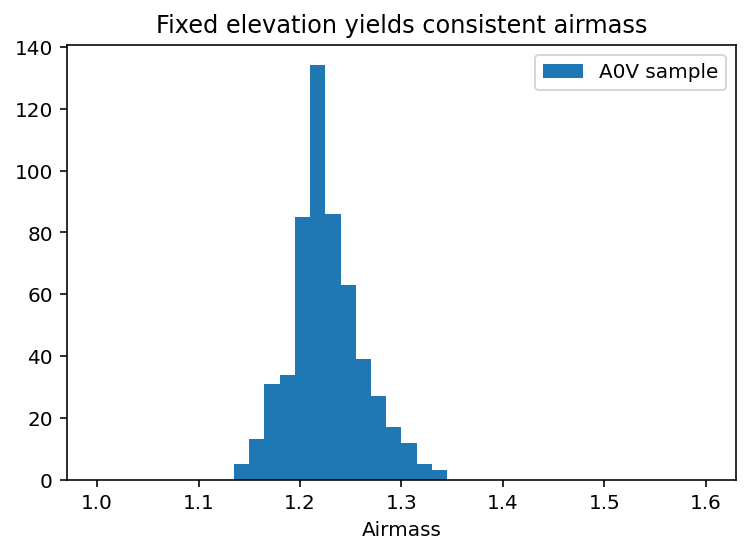

In [17]:
fig=plt.figure(facecolor='white')
bins = np.arange(1.0, 1.6, 0.015)
plt.hist(df.airmass.values, bins=bins, label='A0V sample');
plt.xlabel('Airmass')
#plt.axvline(30, color='#c0392b', linestyle='dotted')
#plt.axvline(40, color='#c0392b', linestyle='dotted', label='HET Limits')
plt.legend(loc='best')
plt.title('Fixed elevation yields consistent airmass')
#plt.savefig('../figures/HET_airmass_A0V.png', dpi=300, bbox_inches='tight');

## What is the range of atmospheric properties probed by the A0V calibrators?

In [18]:
import astropy.units as u
from astropy.units import temperature

In [19]:
temps_F = df.ENVTEM.values * u.imperial.deg_F

In [20]:
xlo = (0.0*u.imperial.deg_F).to(u.Kelvin, equivalencies=temperature())
xhi = (100.0*u.imperial.deg_F).to(u.Kelvin, equivalencies=temperature())

In [21]:
temps_K = temps_F.to(u.Kelvin, equivalencies=temperature())

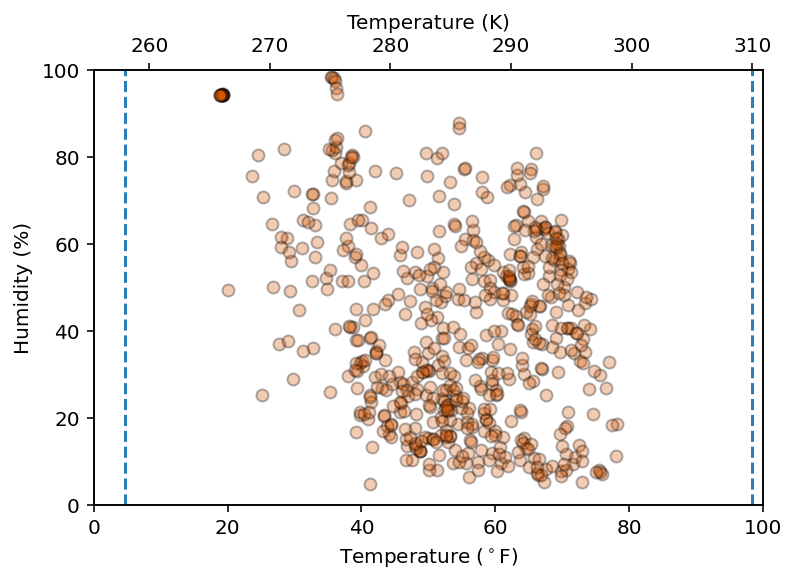

In [22]:
fig, ax1 = plt.subplots(facecolor='white')
ax1.scatter(df.ENVTEM, df.ENVHUM, marker='o', color='#d35400', ec='k', alpha=0.3)
ax1.set_xlabel('Temperature ($^\circ$F)')
ax1.set_xlim(0, 100) # Fahrenheit
ax1.set_ylim(0, 100) # %
ax1.set_ylabel('Humidity (%)')

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

ax2.set_xlabel('Temperature (K)', )  # we already handled the x-label with ax1
ax2.plot(temps_K.value, df.ENVHUM, alpha=0.0)
ax2.axvline(258, color='#2980b9', linestyle='dashed')
ax2.axvline(310, color='#2980b9', linestyle='dashed')
ax2.set_xlim(xlo.value, xhi.value);
#plt.savefig('../figures/HPF_atmospheric_conditions_A0V.png', dpi=300, bbox_inches='tight')

We see some sources observed at high humidity.

## Add a `night_number` column
So we can group by unique nights.  We'll start counting from HPF's first light:

> On the night of November 29-30 2017, HPF acquired first light.

In [23]:
hpf_t0 = Time('2017-11-29T17:00:00.0').jd # 17h UTC is ~noon in Fort Davis

df['night_number'] = df['DATE-OBS'].apply(lambda x: (Time(x).jd - hpf_t0).astype(int))
df['time_from_local_midnight'] = df['DATE-OBS'].apply(lambda x: np.round(np.mod(Time(x).jd - hpf_t0, 1)*24.0 - 12.0, decimals=2))

In [24]:
df.tail()

,file_basename,DATE,OBJECT,DATE-OBS,CAL-OBJ,QRA,QDEC,RA,DEC,ZA,ENVTEM,ENVHUM,ENVPRE,ENVWIN,ENVDIR,ENVSTD,ENVTMIR,ENVTTRU,NREADS,ITIME,EL,airmass,night_number,time_from_local_midnight
567,Goldilocks_20230509T084125_v1.0_0026.spectra.fits,2023-05-09T08:41:25,HR7306_tell_std,2023-05-09T08:41:25.770291,dark,19:16:13.00,+21:23:25.00,19.286562,21.421453,33.530364,65.021,28.065,23.671,10.1420,209.160,9.2970,65.48,65.66,11,117.15,56.469636,1.199626,1986,3.69
568,Goldilocks_20230510T025530_v1.0_0002.spectra.fits,2023-05-10T02:55:30,HR5109_tell_std,2023-05-10T02:55:30.989089,dark,13:34:07.00,+55:20:55.00,13.584304,55.220821,35.451524,67.608,25.298,23.662,11.8200,107.000,5.7428,66.56,68.00,11,117.15,54.548476,1.227587,1987,-2.07
569,Goldilocks_20230512T025927_v1.0_0003.spectra.fits,2023-05-12T02:59:27,HR5238_tell_std,2023-05-12T02:59:27.064659,dark,13:53:51.00,+53:43:43.00,13.912465,53.605978,35.752067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,117.15,54.247933,1.232206,1989,-2.01
570,Goldilocks_20230514T040451_v1.0_0025.spectra.fits,2023-05-14T04:04:51,HR5567_tell_std,2023-05-14T04:04:51.882288,dark,14:56:13.00,+14:26:47.00,14.955042,14.346661,36.401216,52.077,80.886,23.786,11.0720,59.271,12.6610,53.96,53.96,11,117.15,53.598784,1.242419,1991,-0.92
571,Goldilocks_20230515T025025_v1.0_0018.spectra.fits,2023-05-15T02:50:25,HR5109_tell_std,2023-05-15T02:50:25.742444,dark,13:34:07.00,+55:20:55.00,13.584238,55.221411,33.666402,56.556,65.236,23.866,7.3983,46.431,20.1220,57.20,57.56,11,117.15,56.333598,1.201520,1992,-2.16


In [25]:
df.OBJECT.value_counts()

HR6656_tell_std    8
HR5023_tell_std    8
HR3799_tell_std    8
HR4119_tell_std    8
HR2006_tell_std    7
                  ..
HR7757_tell_std    1
HR7202_tell_std    1
HR6533_tell_std    1
HR2191_tell_std    1
HR7306_tell_std    1
Name: OBJECT, Length: 300, dtype: int64